# Analyze the impact of missing values on model performance


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import utils.model_lgb as model_lgb
from utils import eda
from utils import io
import plotly.express as px

In [2]:
RANDOM_SEED = 42
CLASS_NUM = 5
TARGET_KEY = "target"

train_path = "./data/all_in_one_cv_train.parquet"
test_path = "./data/all_in_one_cv_test.parquet"

In [3]:
df_train = pd.read_parquet(train_path)

df_train = df_train.replace([np.inf, -np.inf], np.nan)

X_train = df_train.drop(columns=[TARGET_KEY])
# lgb requires zero-based classes
y_train = df_train[TARGET_KEY] - 1
del df_train

print(f"Train X: {X_train.shape}")
print(f"Train y: {y_train.shape}")

X_train

Train X: (146953, 225)
Train y: (146953,)


,lt,SUM_of_Volume_kb_814,SUM_of_Volume_kb_254,imei_mean_days_usage,SUM_of_Duration_sec_814,SUM_of_Count_events_814,SUM_of_Volume_kb_240,voice_in_mts_avg_dur_mea_mnt3,SUM_of_Duration_sec_240,myvf_day_usage,...,SUM_of_Count_events_933,daily_session_cnt_rate_1503,cnt_sms_allo,SUM_of_Count_events_829,cnt_sms_un_wfp,daily_traffic_rate_1301,SUM_of_Count_events_690,device_brand_apple,conn_out_uniq_cnt_mea_wk1,cnt_sms_tiktok
abon_id,,,,,,,,,,,,,,,,,,,,,
1525928,6.125000,0.0000,74.750,40.531250,0.0000,0.00000,144.1250,24.093750,103.75,34.156250,...,0.0,0.008972,0.0,33.750000,0.0,0.0,54.03125,1.0,8.335938,0.0
1530471,6.132812,99.8125,104.750,51.875000,87.0000,38.37500,67.3125,23.421875,69.75,31.656250,...,0.0,0.014404,0.0,0.000000,0.0,0.0,31.65625,0.0,10.828125,0.0
1541528,6.121094,147.5000,221.875,32.875000,85.4375,43.15625,203.8750,35.437500,160.75,50.718750,...,0.0,0.004547,0.0,17.765625,0.0,0.0,99.62500,0.0,7.175781,0.0
1542028,6.132812,NaN,NaN,30.703125,NaN,NaN,NaN,0.000000,NaN,57.531250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1542203,6.132812,NaN,NaN,40.406250,NaN,NaN,NaN,0.000000,NaN,45.312500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132486100,2.763672,NaN,NaN,7.175781,NaN,NaN,NaN,0.000000,NaN,0.000000,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.000000,0.0
132550466,2.667969,NaN,NaN,8.335938,NaN,NaN,NaN,19.171875,NaN,8.335938,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,4.210938,0.0
132551440,2.558594,NaN,NaN,7.175781,NaN,NaN,NaN,0.000000,NaN,7.175781,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.000000,0.0


In [4]:
df_missing = eda.print_missing(X_train)

No columns with inf found!
Missing values report:
Features count without missing values: 2

Percent of missing values by feature (features count 223):
                                   Total   Rate
AMA                               141194  96.08
tsoa_chat_cnt                     134603  91.60
day_end_gba                       133755  91.02
device_ios_version                131827  89.71
DNZ_DAYS_from_last_year2          126693  86.21
device_price                      121459  82.65
DNZ_MAX_days_closed_loan_year5    120269  81.84
DNZ_MIN_days_closed_loan_year5    120269  81.84
DNZ_COUNT_closed_loan_year5       119811  81.53
DNZ_DAYS_from_last_year5          119811  81.53
tsoa_call_cnt                     112565  76.60
sms_per_call_cnt                  110327  75.08
Internet                          106701  72.61
total_cnt_sms_in                   43351  29.50
cnt_sms_pmml                       43351  29.50
total_cnt_sms                      43351  29.50
cnt_sms_privatbank               

In [5]:
predict, model = model_lgb.load("2024_07_06_lgb_final_cv_2_boruta_acc_5144")

baseline_preds = predict(X_train)
acc_baseline = accuracy_score(
    y_train,
    baseline_preds,
)
print(f"Baseline accuracy: {acc_baseline}")

Baseline accuracy: 0.521513681245024


In [6]:
def collect_acc_stats():
    cols_to_filter = df_missing.index.to_list()
    accs = []
    rows = []

    for key in cols_to_filter:
        tr = X_train.dropna(subset=[key])

        acc = accuracy_score(y_train.loc[tr.index], predict(tr))

        print(f"Acc: {acc}. Rows: {tr.shape[0]}. Key: {key}")

        accs.append(acc)
        rows.append(tr.shape[0])

    return pd.DataFrame(
        {
            "feature": cols_to_filter,
            "acc": accs,
            "rows": rows,
        }
    ).sort_values(by="acc", ascending=False)


df_acc_stats = io.run_cached("./data/acc_vs_missing.parquet", collect_acc_stats)
df_acc_stats

,feature,acc,rows
3,device_ios_version,0.613711,15126
2,day_end_gba,0.573420,13198
12,Internet,0.558183,40252
31,cnt_sms_un_wfp,0.551254,103602
25,avg_cnt_sms,0.551254,103602
...,...,...,...
205,clc_no_vas_roam_std_mnt3,0.521550,146916
204,non_accum_internet_vol_mea_mnt1,0.521550,146916
222,voice_in_mts_avg_dur_min_mnt1,0.521550,146916
175,days_of_end_last_ppm,0.520445,140985


In [7]:
df_grouped_acc = (
    df_acc_stats.groupby("rows")
    .agg(["max"])
    .droplevel(1, axis=1)
    .sort_values(
        by="acc",
        ascending=False,
    )
    .reset_index()
)
df_grouped_acc["missing_ratio%"] = (1 - df_grouped_acc["rows"] / len(X_train)) * 100
df_grouped_acc

,rows,feature,acc,missing_ratio%
0,15126,device_ios_version,0.613711,89.706913
1,13198,day_end_gba,0.573420,91.018897
2,40252,Internet,0.558183,72.608929
3,103602,total_cnt_sms_in,0.551254,29.499908
4,36626,sms_per_call_cnt,0.548654,75.076385
5,112989,loc_market_share,0.547496,23.112152
6,111740,device_height_mm,0.546608,23.962083
7,116546,device_days_usage,0.546582,20.691650
8,119792,daily_session_dur_rate_546,0.546005,18.482780
9,119798,daily_traffic_rate_992,0.546002,18.478697


array([<Axes: title={'center': '0'}, ylabel='Frequency'>,
       <Axes: title={'center': '1'}, ylabel='Frequency'>,
       <Axes: title={'center': '2'}, ylabel='Frequency'>,
       <Axes: title={'center': '3'}, ylabel='Frequency'>,
       <Axes: title={'center': '4'}, ylabel='Frequency'>], dtype=object)

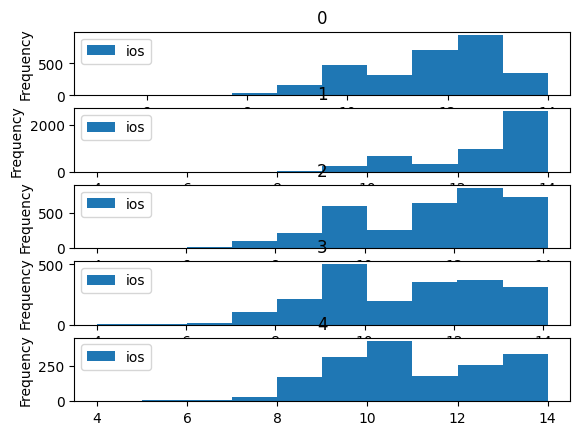

In [8]:
pd.DataFrame(
    {
        "ios": X_train["device_ios_version"],
        "group": y_train,
    }
).plot.hist(by="group")

<Axes: >

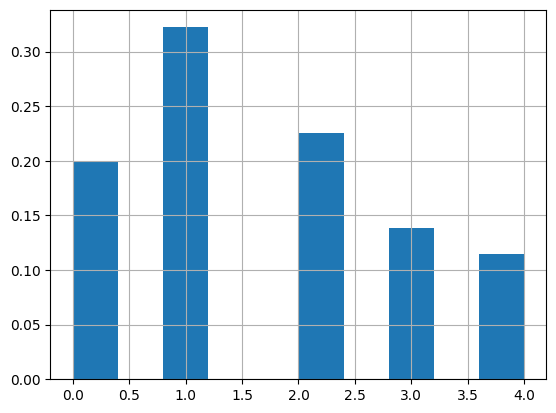

In [17]:
def normalized_hist(series):
    return series.hist(weights=np.ones_like(series.index) / len(series.index))


normalized_hist(y_train.loc[X_train.dropna(subset=["device_ios_version"]).index])

<Axes: >

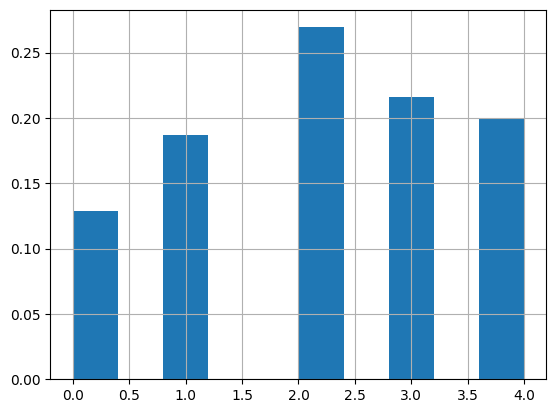

In [21]:
normalized_hist(y_train)

So the real reason of such great accuracy boost is related to different distribution of categories among iOS usage. We just have more samples where model can give more accurate predictions.

## Check model performance without `device_ios_version` feature

As we can see above, when we leaving rows with filled `device_ios_version` we are getting accuracy 0.61. Let's check that `device_ios_version` is really the feature that has such a high impact. We will train the model without `device_ios_version` feature and then check accuracy on entire dataset and on the subset where previously `device_ios_version` was not missed.


In [9]:
def test_ios():
    banned_feature = "device_ios_version"
    df_test = pd.read_parquet(test_path)

    df_test = df_test.replace([np.inf, -np.inf], np.nan)

    X_test_alt = df_test.drop(columns=[TARGET_KEY, banned_feature])
    # lgb requires zero-based classes
    y_test = df_test[TARGET_KEY] - 1
    del df_test

    print(f"Test X: {X_test_alt.shape}")
    print(f"Test y: {y_test.shape}")

    X_train_alt = X_train.drop(columns=[banned_feature])

    predict, model = model_lgb.train_multiclass(
        X_train=X_train_alt,
        y_train=y_train,
        X_test=X_test_alt,
        y_test=y_test,
        # number 75
        params={
            "boosting_type": "gbdt",
            "num_iterations": 350,
            "learning_rate": 0.27831449040881007,
            "num_leaves": 14,
            "min_data_in_leaf": 1360,
            "max_depth": 1,
            "feature_fraction": 0.9000000000000001,
            "bagging_fraction": 0.4,
            "bagging_freq": 2,
            "lambda_l1": 0.0011830914968329104,
            "lambda_l2": 0.012417262351779968,
            "min_gain_to_split": 0.6889417143854851,
            "path_smooth": 0.03645227176885784,
            "extra_trees": True,
        },
        num_class=CLASS_NUM,
        seed=RANDOM_SEED,
        name=f"2024_07_11_lgb_final_cv_2_boruta_wo_ios",
    )

    X_train_no_ios = X_train.dropna(subset=[banned_feature])

    acc_with_na = accuracy_score(
        y_train,
        predict(X_train_alt),
    )
    acc_wo_na = accuracy_score(
        y_train.loc[X_train_no_ios.index],
        predict(X_train_alt.loc[X_train_no_ios.index]),
    )

    print(
        f"Accuracy with na: {acc_with_na}. Accuracy w/o na: {acc_wo_na}. Delta: {acc_with_na-acc_wo_na}"
    )


test_ios()

Test X: (44307, 224)
Test y: (44307,)
Accuracy with na: 0.5208808258422761. Accuracy w/o na: 0.6094803649345498. Delta: -0.0885995390922737


So the issue not in the `device_ios_version` feature alone. The issue is in the entire rows that was dropped due to absence of `device_ios_version`.


## Explore relation between na count and accuracy


In [10]:
nbins = 40
df_na_stats = pd.DataFrame(
    {
        "na_count": X_train.isna().sum(axis=1),
        "y_true": y_train,
        "y_pred": baseline_preds,
    }
)

df_na_stats["tp"] = df_na_stats["y_true"] == df_na_stats["y_pred"]

display(df_na_stats)
print(f"Unique counts: {df_na_stats['na_count'].sort_values(ascending=True).unique()}")

px.histogram(
    df_na_stats,
    x="na_count",
    color="tp",
    facet_row="y_true",
    barmode="overlay",
    nbins=nbins,
    color_discrete_map={True: "green", False: "red"},
)

,na_count,y_true,y_pred,tp
abon_id,,,,
1525928,12,3,3,True
1530471,13,3,4,False
1541528,10,2,3,False
1542028,174,2,2,True
1542203,174,4,4,True
...,...,...,...,...
132486100,154,3,1,False
132550466,150,2,1,False
132551440,153,2,1,False


Unique counts: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 188 189 192 199 218 222]


In [11]:
# df_na_stats["bin"] = pd.cut(df_na_stats["na_count"], range(0, 200, 10))
# with pd.option_context("display.max_rows", None):
#   display(df_na_stats.groupby(["y_true", "tp", "bin"]).sum())
# # df_na_stats

## Count of na in relation to feature importance


In [20]:
df_boruta = pd.read_parquet("./data/borutashap_final_tunning.parquet")
df_boruta = df_boruta[df_boruta["Decision"] == "Accepted"].reset_index(drop=True)

In [22]:
df_na_vs_importance = pd.DataFrame(
    {
        "feature": df_boruta["Features"],
        "importance": df_boruta["Average Feature Importance"],
    }
).merge(
    X_train.isna().sum(axis=0).rename("na_count"),
    how="left",
    left_on="feature",
    right_index=True,
)

df_na_vs_importance.head(30)

,feature,importance,na_count
0,lt,14.554338,600
1,SUM_of_Volume_kb_814,9.363325,27155
2,SUM_of_Volume_kb_254,5.958358,27155
3,imei_mean_days_usage,5.687875,351
4,SUM_of_Duration_sec_814,4.917057,27155
5,SUM_of_Count_events_814,3.838774,27155
6,SUM_of_Volume_kb_240,3.154899,27155
7,voice_in_mts_avg_dur_mea_mnt3,2.680208,37
8,SUM_of_Duration_sec_240,2.643527,27155
9,myvf_day_usage,2.595924,14250


In [54]:
df_abons_wo_data = X_train[X_train["SUM_of_Volume_kb_814"].isna()]

with pd.option_context("display.max_columns", None):
    display(df_abons_wo_data.head(20))

print(f"Mean na count per subscriber: {df_abons_wo_data.isna().sum(axis=1).mean()}")

,lt,SUM_of_Volume_kb_814,SUM_of_Volume_kb_254,imei_mean_days_usage,SUM_of_Duration_sec_814,SUM_of_Count_events_814,SUM_of_Volume_kb_240,voice_in_mts_avg_dur_mea_mnt3,SUM_of_Duration_sec_240,myvf_day_usage,SUM_of_Count_events_240,imei_mean_long_days_usage,imei_mean_day_announced,SUM_of_Volume_kb_777,SUM_of_Volume_kb_267,block_all_dur_min_mnt3,Balance_uah,voice_in_fix_tar_dur_mea_mnt3,SUM_of_Count_events_1414,TM_ID,SUM_of_Duration_sec_1414,DNZ_DAYS_from_last_year5,voice_in_cmpttrs_avg_durmea_mnt3,SUM_of_Duration_sec_320,voice_in_mts_avg_dur_min_mnt3,SUM_of_Volume_kb_246,Internet,daily_session_cnt_rate_1020,min_paym_6_month,imei_max_price,DNZ_DAYS_from_last_year2,conn_out_uniq_cnt_mea_mnt3,SUM_of_Duration_sec_175,all_clc_mea_mnt3,imei_mean_price,voice_out_cmpttrs_avg_dumax_mnt3,SUM_of_Duration_sec_1119,voice_in_td_cnt_std_mnt3,non_accum_internet_vol_std_mnt3,SUM_of_Volume_kb_175,conn_in_uniq_cnt_mea_mnt3,SUM_of_Volume_kb_1414,SUM_of_Count_events_677,SUM_of_Duration_sec_2542,conn_in_uniq_cnt_std_mnt3,avg_session_sec,SUM_of_Duration_sec_1503,non_accum_internet_vol_max_mnt3,SUM_of_Duration_sec_267,SUM_of_Volume_kb_739,SUM_of_Volume_kb_1119,DNZ_MAX_days_closed_loan_year5,MAX_of_day_cnt_1119,daily_session_cnt_rate_1373,SUM_of_Duration_sec_897,SUM_of_Volume_kb_819,day_end_gba,MAX_of_day_cnt_267,daily_traffic_rate_254,non_accum_internet_vol_mea_mnt3,device_days_usage,MAX_of_day_cnt_246,SUM_of_Duration_sec_1998,voice_out_td_cnt_std_mnt3,daily_traffic_rate_320,SUM_of_Volume_kb_677,SUM_of_Volume_kb_710,daily_session_cnt_rate_1125,block_all_dur_mea_mnt3,tsoa_call_cnt,daily_session_cnt_rate_933,SUM_of_Count_events_320,voice_mts_in_nwork_part_max_mnt3,device_price,days_of_last_ppm,device_ios_version,SUM_of_Volume_kb_897,clc_no_vas_roam_mea_mnt3,loc_market_share,daily_session_dur_rate_1373,MV_Traf_Cont_inc_s_Cnt,daily_session_cnt_rate_240,daily_session_cnt_rate_710,conn_out_uniq_cnt_max_mnt3,SUM_of_Volume_kb_948,SUM_of_Count_events_246,SUM_of_Volume_kb_829,daily_session_dur_rate_1397,SUM_of_Count_events_1157,MAX_of_day_cnt_739,avg_cnt_sms,daily_traffic_rate_1314,clc_no_vas_roam_std_mnt3,voice_mts_in_nwork_part_mea_mnt3,avg_session_traffic_kb,SUM_of_Count_events_381,voice_mts_out_drest_partmea_mnt3,total_cnt_sms_in,MAX_of_day_cnt_604,SUM_of_Volume_kb_2558,SUM_of_Count_events_819,days_of_end_last_ppm,MAX_of_day_cnt_2010,daily_traffic_rate_814,voice_mts_in_nrest_part_max_mnt3,daily_session_cnt_rate_2558,SUM_of_Count_events_1119,avg_days_per_app,MAX_of_day_cnt_2555,daily_session_cnt_rate_739,voice_in_mts_avg_dur_min_mnt1,SUM_of_Duration_sec_933,SUM_of_Volume_kb_1314,daily_session_dur_rate_933,tsoa_chat_cnt,MAX_of_day_cnt_710,daily_traffic_rate_604,MAX_of_day_cnt_1523,SUM_of_Volume_kb_868,non_accum_internet_vol_min_mnt1,non_accum_internet_vol_mea_mnt1,total_cnt_sms,cnt_sms_taxi-838,daily_session_dur_rate_246,content_cnt_mea_mnt3,voice_mts_in_dwork_part_mea_mnt3,SUM_of_Duration_sec_739,SUM_of_Count_events_1020,voice_in_td_cnt_mea_mnt3,MAX_of_day_cnt_1503,MAX_of_day_cnt_1871,SUM_of_Count_events_739,daily_session_cnt_rate_175,MV_Traf_innet_out_v_Min,cnt_sms_facebook,SUM_of_Volume_kb_1523,SUM_of_Duration_sec_992,voice_out_td_cnt_mea_mnt3,cnt_sms_fishka,SUM_of_Volume_kb_381,daily_traffic_rate_1399,total_call_dur,SUM_of_Volume_kb_1355,daily_session_dur_rate_1119,SUM_of_Duration_sec_1394,SUM_of_Count_events_992,MAX_of_day_cnt_240,SUM_of_Volume_kb_2018,cnt_sms_uklon,SUM_of_Duration_sec_1462,MAX_of_day_cnt_2542,voice_out_tar_dur_std_mnt3,avg_daily_session_sec_sum,cnt_sms_epicentrk,avg_call_dur,voice_in_cmpttrs_td_cnt_std_mnt3,daily_traffic_rate_1503,cnt_sms_colins,SUM_of_Volume_kb_1462,daily_session_cnt_rate_2027,SUM_of_Duration_sec_254,avg_session_cnt_per_app,DNZ_COUNT_closed_loan_year5,voice_mts_in_nrest_part_mea_mnt3,daily_session_dur_rate_948,sms_in_cnt_std_mnt3,DNZ_MIN_days_closed_loan_year5,SUM_of_Volume_kb_1373,conn_out_uniq_cnt_mea_mnt1,daily_session_dur_rate_716,daily_session_cnt_rate_254,SUM_of_Count_events_254,daily_traffic_rate_992,SUM_of_Count_

Mean na count per subscriber: 165.50668385196096


There was a hypothesis that the issue with new subscribers with low `lt` and `imei_mean_days_usage` and therefore low amount of data collected. But it turns out that our subscribers are in the same range as the most part of subscribers. So that's not the reason.


<Axes: >

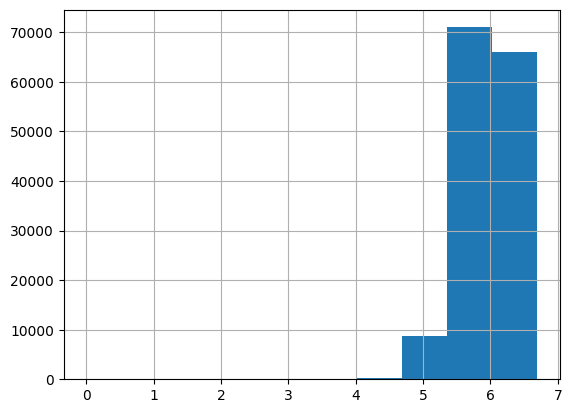

In [55]:
X_train["lt"].hist()

In [51]:
def test_acc_on_bnum_dpi_existance():
    tr = X_train[~(X_train["SUM_of_Volume_kb_814"].isna())]

    acc = accuracy_score(y_train.loc[tr.index], predict(tr))

    print(f"W/o na Acc: {acc}. Rows: {tr.shape[0]}")

    tr = X_train[X_train["SUM_of_Volume_kb_814"].isna()]

    acc = accuracy_score(y_train.loc[tr.index], predict(tr))

    print(f"na only Acc: {acc}. Rows: {tr.shape[0]}")


test_acc_on_bnum_dpi_existance()

W/o na Acc: 0.5460024374363512. Rows: 119798
na only Acc: 0.41347818081384646. Rows: 27155


We've got +2% improvement. Great but not that much. So the fact that subscriber does not have enough bnum/dpi data does not have a big impact on the accuracy. Moreover if we predict only on those rows with na — we still get 41% accuracy which is not that bad for the subscriber with high amount of missing data.


In [64]:
def collect_acc_stats_by_top_feature():
    cols_to_filter = df_boruta["Features"].to_list()
    accs = []
    rows = []

    for key in cols_to_filter:
        tr = X_train.dropna(subset=[key])

        acc = accuracy_score(y_train.loc[tr.index], predict(tr))

        print(f"Acc: {acc}. Rows: {tr.shape[0]}. Key: {key}")

        accs.append(acc)
        rows.append(tr.shape[0])

    return (
        pd.DataFrame(
            {
                "feature": cols_to_filter,
                "acc": accs,
                "rows": rows,
            }
        )
        .merge(
            pd.DataFrame(
                {
                    "feature": df_boruta["Features"],
                    "importance": df_boruta["Average Feature Importance"],
                }
            ),
            how="left",
            on="feature",
        )
        .sort_values(by=["importance", "acc"], ascending=False)
    )


df_acc_top_feature_stats = io.run_cached(
    "./data/acc_vs_missing_top_features.parquet", collect_acc_stats_by_top_feature
)

px.histogram(df_acc_top_feature_stats, x="acc").show()

with pd.option_context("display.max_rows", None):
    display(df_acc_top_feature_stats.sort_values(by=["rows", "importance"]))

,feature,acc,rows,importance
188,AMA,0.529606,5759,-0.175107
114,tsoa_chat_cnt,0.538704,12350,0.051641
56,day_end_gba,0.573420,13198,0.471285
75,device_ios_version,0.613711,15126,0.286803
30,DNZ_DAYS_from_last_year2,0.526259,20260,0.915719
73,device_price,0.539343,25494,0.311640
166,DNZ_MIN_days_closed_loan_year5,0.525371,26684,-0.120681
51,DNZ_MAX_days_closed_loan_year5,0.525371,26684,0.576853
162,DNZ_COUNT_closed_loan_year5,0.524353,27142,-0.108861
21,DNZ_DAYS_from_last_year5,0.524353,27142,1.237561
